In [1]:
import matplotlib.pyplot as plt

In [2]:
from scipy import signal

In [3]:
from scipy import linalg

In [4]:
import numpy as np

In [5]:
import IPython

In [6]:
def plot_anc_results(e, w=None, weight_plot='response', labels=None):
    """ Plot the results of the ANC algorithm.
        @param error_history
        @param weight_history
    """
    
    if w is not None:
        fig, ax = plt.subplots(2, 1, figsize=(18, 18))
        error_ax = ax[0]
    else:
        fig, ax = plt.subplots(1, 1, figsize=(18, 9))
        error_ax = ax
        
    if labels is None:
        labels = ['Ruido con filtrado pasivo', 'Ruido con ANC']
    for k, error in enumerate(e):
        error_ax.plot(error, label=labels[k])
    error_ax.set_ylabel('$e(n)$', fontsize=16)
    error_ax.set_xlabel('$n$', fontsize=16)
    error_ax.grid()
    error_ax.legend(loc='upper right', fontsize=14)
    
    if w is not None:
        if weight_plot == 'response':
            ax[1].stem(w, use_line_collection=True)
            ax[1].set_ylabel('$w_n$', fontsize=16)
            ax[1].set_xlabel('$n$', fontsize=16)
            ax[1].grid()
        elif weight_plot == 'history':
            for i in range(w.shape[0]):
                ax[1].plot(w[i,:])
            ax[1].set_ylabel('$w_i(n)$', fontsize=16)
            ax[1].set_xlabel('$n$', fontsize=16)
            ax[1].grid()
    
    plt.show()

In [7]:
def total_attenuation(x, y, fs, nperseg):
    """ Calculate attenuation in dB
        @param x input signal
        @param y output signal
        @param fs  sampling frequency
        @param nperseg
        @returns fnn, Rnn, fee, Ree, A Attenuation in dB
    """
    # Estimate signals' power spectral density
    fnn, Rnn = signal.welch(x, fs=fs, window='hamming', nperseg=nperseg)
    fee, Ree = signal.welch(y, fs=fs, window='hamming', nperseg=nperseg)

    A = -10*np.log10(Ree.sum() / Rnn.sum())
    return A, (fnn, Rnn, fee, Ree)

In [8]:
import json

In [9]:
class AcousticModel:
    """ The AcousticModel class exposes an inteface to simulate the interaction
        with the physical system. This allows us to encapsulate the physical model
        to easily simulate it while developing the active noise cancelling system.
    """
    
    def __init__(self):
        raise NotImplemented
    
    def __len__(self):
        """ Returns the length of the acoustic model, understood as the amount
            of samples for simulation that it contains.
        """
        raise NotImplemented
    
    def set_noise(self, x):
        """ Set the noise samples
            @param x Array containing noise samples for the acoustic simulation
        """
        raise NotImplemented

    def reference_microphone(self):
        """ Takes a sample from the reference microphone.
            @return Reference signal sample
        """
        raise NotImplemented
    
    def error_microphone(self):
        """ Takes a sample from the error microphone.
            @return Error signal sample
        """
        raise NotImplemented
    
    def speaker(self, y):
        """ Sets the output sample for the speaker.
            @param y Output signal sample
        """
        raise NotImplemented
    
    def step(self):
        """ Moves forward to the next sampling time or instant.
            @return Boolean indicating it has not reached the end of the samples
        """
        raise NotImplemented
    
    def reset(self):
        """ Resets the sampling time to zero.
        """
        raise NotImplemented

## Base de datos PANDAR
La base de datos utilizada tiene mediciones para los caminos primario, secundario y de feedback de los auriculares BoseQC20 para una cámara anecoica y una cámara acústica. Además, proveen mediciones de parte de la electrónica utilizada en las mediciones (ADC y DAC) para compensar los resultados. Este procesamiento se realiza en Matlab y se guarda el resultado en el archivo JSON accedido en este notebook.

Se utilizan las mediciones de la cámara anecoica porque al no tener reflexiones la respuesta impulsiva del camino primario es más corta, lo cual acelera los tiempos de procesamiento y agiliza el trabajo.

In [10]:
class BoseQC20(AcousticModel):
    """ Acoustic simulation of the BoseQC20 headphones based on the measurements
        performed by 
            'Acoust path database for ANC in-ear headphone development'
            Stefan LIEABICH, Johannes FABRY, Peter JAX, Peter VARY

        NOTE: It only supports simulating the primary acoustic path
    """
    
    def __init__(self, filepath, secondary_enable=False, feedback_enable=False):
        """ Initializes the BoseQC20 instance
            @param filepath Filepath to the JSON file containing the dataset
        """
        
        # Open the JSON file containing measurements of the BoseQC20 headphones
        self.acoustic_paths_filepath = filepath
        self.acoustic_paths_file = open(self.acoustic_paths_filepath, 'r')
        self.acoustic_paths_data = json.load(self.acoustic_paths_file)
        
        # Choose the physical or acoustic paths from the dataset
        self.p = self.acoustic_paths_data['anechoic_chamber']['primary'][0][0]          # Primary acoustic path impulse response estimation
        self.g = self.acoustic_paths_data['anechoic_chamber']['secondary'][0]           # Secondary acoustic path impulse response estimation
        self.f = self.acoustic_paths_data['anechoic_chamber']['feedback'][0]            # Feedback acoustic path impulse response estimation
        
        # Cut the responses
        self.p = self.p[:2000]
        self.g = self.g[:150]
        self.f = self.f[:150]
        
        # Initialize internal signals
        self.x = None                                                              # Input signal of the acoustic model for simulation
        self.y = np.zeros(len(self.g))                                             # Saves the speaker sample
        self.n = -1                                                                # Current sampling time or instant
        self.secondary_enable = secondary_enable                                   # Whether the secondary acoustic path is simulated
        self.feedback_enable = feedback_enable
    
    def __len__(self):
        """ Returns the length of the acoustic model, understood as the amount
            of samples for simulation that it contains.
        """
        return len(self.x)
    
    def set_noise(self, x):
        """ Set the noise samples
            @param x Array containing noise samples for the acoustic simulation
        """
        # Set the noise samples
        self.x = x
        
        # Calculate the response of the primary acoustic path
        self.d = signal.lfilter(self.p, [1.0], self.x)

    def reference_microphone(self):
        """ Takes a sample from the reference microphone.
            @return Reference signal sample
        """
        # Calculate the feedback's path influence in the input measurement
        feedback_sample = np.dot(self.f, self.y) if self.feedback_enable else 0

        return self.x[self.n] + feedback_sample
    
    def error_microphone(self):
        """ Takes a sample from the error microphone.
            @return Error signal sample
        """
        if self.secondary_enable:
            return self.d[self.n] + np.dot(self.g, self.y)
        else:
            return self.d[self.n] + self.y[0]
    
    def speaker(self, y):
        """ Sets the output sample for the speaker.
            @param y Output signal sample
        """
        self.y = np.roll(self.y, 1)
        self.y[0] = y
    
    def step(self):
        """ Moves forward to the next sampling time or instant.
            @return Boolean indicating it has not reached the end of the samples
        """
        if self.n < len(self.x) - 1:
            self.n += 1
            return True
        else:
            return False
    
    def reset(self):
        """ Resets the sampling time to zero.
        """
        self.n = -1

In [11]:
# Create noise samples to stimulate the acoustic system and
# validate whether the active noise cancelling system is working
fs = 48000                        # Sampling frequency
tt = 5                            # Total time of simulation
dtt = int(fs * tt)                # Discrete total time of simuluation
x_white = np.random.normal(size=dtt)

In [12]:
# Listen to the noise
IPython.display.Audio(x_white, rate=fs)

In [13]:
def anc_complete_system_nlms(model, g, f, order, step, initial_weights=None, weight_history=False, delta=1e-7):
    """ Active Noise Cancelling
        Apply the active noise cancelling algorithm to compensate the
        noise by modeling the primary acoustic path and compensating the 
        secondary and feedback acoustic paths.
        
        @param model Instance of an acoustic model for simulation
        @param g Secondary acoustic path
        @param f Feedback acoustic path 
        @param order Order of the filter
        @param step Step size used for LMS
        @param initial_weights Initialization of weights
        @param weight_history Enable recording the weight evolution throughout the simulation
        @return Tuple containing error and coefficients of each iteration of the LMS algorithm
                (error_signal, coefficients_evolution)
    """    
    # Validate metaparameters
    if type(order) is int:
        if order < 1:
            raise ValueError("The minimum order is 1")
    else:
        raise ValueError("Order argument must be integer")
    if step <= 0:
        raise ValueError("The step size must be a positive value")
        
    # Parameters
    N = len(model)
    
    # Initialize arrays
    rg = np.zeros(len(g))      # Buffer for the input of G(z)
    rw = np.zeros(order)       # Buffer for the input of W(z)
    rlms = np.zeros(order)     # Buffer for the input of the LMS update equation
    y = np.zeros(len(f))       # Buffer for the input of F(z)
    w = np.zeros(order) if initial_weights is None else initial_weights
    e_n = np.zeros(N)
    if weight_history:
        w_n = np.zeros((order, N))
    i = 0
    
    # Sample processing loop
    while (model.step()):
        rg = np.roll(rg, 1)
        rw = np.roll(rw, 1)
        rlms = np.roll(rlms, 1)
        rg[0] = rw[0] = model.reference_microphone()
        feedback = np.dot(f, y)
        rg[0] -= feedback
        rw[0] -= feedback
        y = np.roll(y, 1)
        y[0] = -np.dot(w, rw)
        model.speaker(y[0])
        e = model.error_microphone()
        rlms[0] = np.dot(g, rg)
        w += step / ((np.dot(rw, rw) / len(rw)) + delta) * rlms * e
        e_n[i] = e
        if weight_history:
            w_n[:,i] = w
        i += 1
    
    if weight_history:
        return e_n, w, w_n
    else:
        return e_n, w

In [14]:
x = x_white
print(x.max())

4.220169184358959


In [21]:
print(len(x))
N = len(x)

240000


In [33]:
A = np.array([2, 3])
B = np.array([2, 3])
C = A / B
print(C)

[1. 1.]


In [46]:
def plot_error_evolution(passive_noise, anc_error, nperseg, fs):

    # Number of iterations and time axis
    N = min(len(passive_noise), len(anc_error))
    it_count = N // nperseg
    t = np.linspace(0, N / fs, it_count)
    
    # Calculate energies on the time domain
    Ein = np.array([ np.sum(passive_noise[k*nperseg:(k+1)*nperseg] ** 2) for k in range(it_count)])
    Eout = np.array([ np.sum(anc_error[k*nperseg:(k+1)*nperseg] ** 2) for k in range(it_count)])
    
    # Calculate Noise Reductions for each segment
    NRs = -10*np.log10(Eout / Ein)
    
    plt.plot(t, NRs, marker='o')
    plt.ylabel("NR [dB]")
    plt.xlabel("t [s]")
    plt.title('Atenuación en función del tiempo')
    plt.grid()
    plt.show()

In [30]:
# Create the simulated headphone and the test noise
headphone = BoseQC20('../samples/BoseQC20.json', secondary_enable=True, feedback_enable=True)
headphone.set_noise(x)

# Run the algorithm
error, weights = anc_complete_system_nlms(headphone, headphone.g, headphone.f, order=3000, step=0.004)

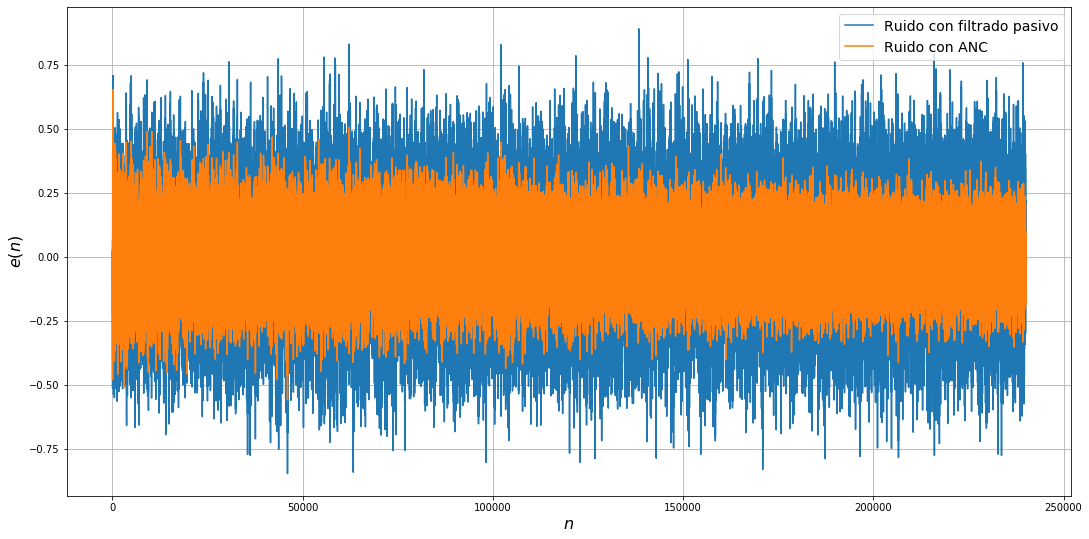

In [31]:
# Plot the ANC results
plot_anc_results([headphone.d, error])

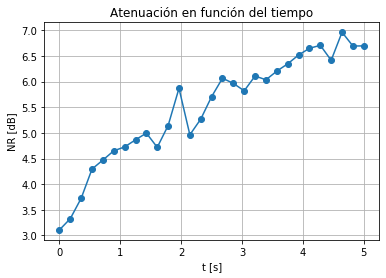

In [49]:
plot_error_evolution(headphone.d, error, 8192, fs)